In [1]:
# 导入模块
import Solarclip_test
from Solarclip_test import plot_matrix_with_images,calculate_loss,calculate_loss_reconstruction
from Data import Solardataloader_subset
from Model.SolarCLIP import get_model_from_args
from Model.decoder import get_decoder_from_args

import torch
import numpy as np
import matplotlib.pyplot as plt

import os
import torch 
import json
from types import SimpleNamespace

In [2]:
encoder_json_path = './configs/args1.json'
decoder_json_path = './configs/decoder/args1.json'
load_id = 200

with open(encoder_json_path, 'r') as f:
    args_encoder = json.load(f)
    args_encoder = SimpleNamespace(**args_encoder)
for arg in vars(args_encoder):
    print(f"{arg:<30}: {getattr(args_encoder, arg)}")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

with open(decoder_json_path, 'r') as f:
    args = json.load(f)
    args = SimpleNamespace(**args)


encoder_checkpoint_path = args_encoder.checkpoint_path
encoder_checkpoint_path += args_encoder.token_type + '/'
for i in range(len(args_encoder.modal_list)):
    encoder_checkpoint_path += args_encoder.modal_list[i] + '_'
    for j in range(len(args_encoder.enhance_list[i])):
        encoder_checkpoint_path += str(args_encoder.enhance_list[i][j]) + '_'
print(encoder_checkpoint_path)

if args.load_id is None:    #todo
    load_id = args_encoder.epochs
    for i in range(21):
        _ = f'{encoder_checkpoint_path}/model/epoch_{i}.pt'
        if os.path.exists(_):
            load_encoder_dir = _
    assert load_encoder_dir is not None
else:
    load_encoder_dir = f'{encoder_checkpoint_path}/model/epoch_{args.load_id}.pt'
    load_decoder_dir = f'{encoder_checkpoint_path}/decoder/model/epoch_{args.load_id}.pt'

SolarModel = get_model_from_args(args_encoder)
SolarModel.load_state_dict(torch.load(load_encoder_dir)['model'])
SolarModel = SolarModel.to(device)

Decoder = get_decoder_from_args(args).to(device)  
Decoder.load_state_dict(torch.load(load_decoder_dir)['model'])
Decoder = Decoder.to(device)


config_dir                    : None
batch_size                    : 400
learning_rate                 : 0.1
epochs                        : 100
test_freq                     : 10
save_freq                     : 2
num_workers                   : 16
embed_dim                     : 512
vision_width                  : 768
image_resolution_mag          : 224
vision_layers_mag             : 12
vision_patch_size_mag         : 32
image_resolution_H            : 224
vision_layers_H               : 12
vision_patch_size_H           : 32
token_type                    : all embedding
modal_list                    : ['magnet', '0094']
enhance_list                  : [['None', 1], ['None', 1]]
image_preprocess              : [224, 0.5, 90]
device                        : cuda:0
checkpoint_path               : /mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/
/mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/all embedding/magnet_None_1_0094_None_1_
loading model from /mnt/nas/home/huxing/202

Text(0.5, 1.0, 'Test Acc\n Last 10% mean: 17.81%')

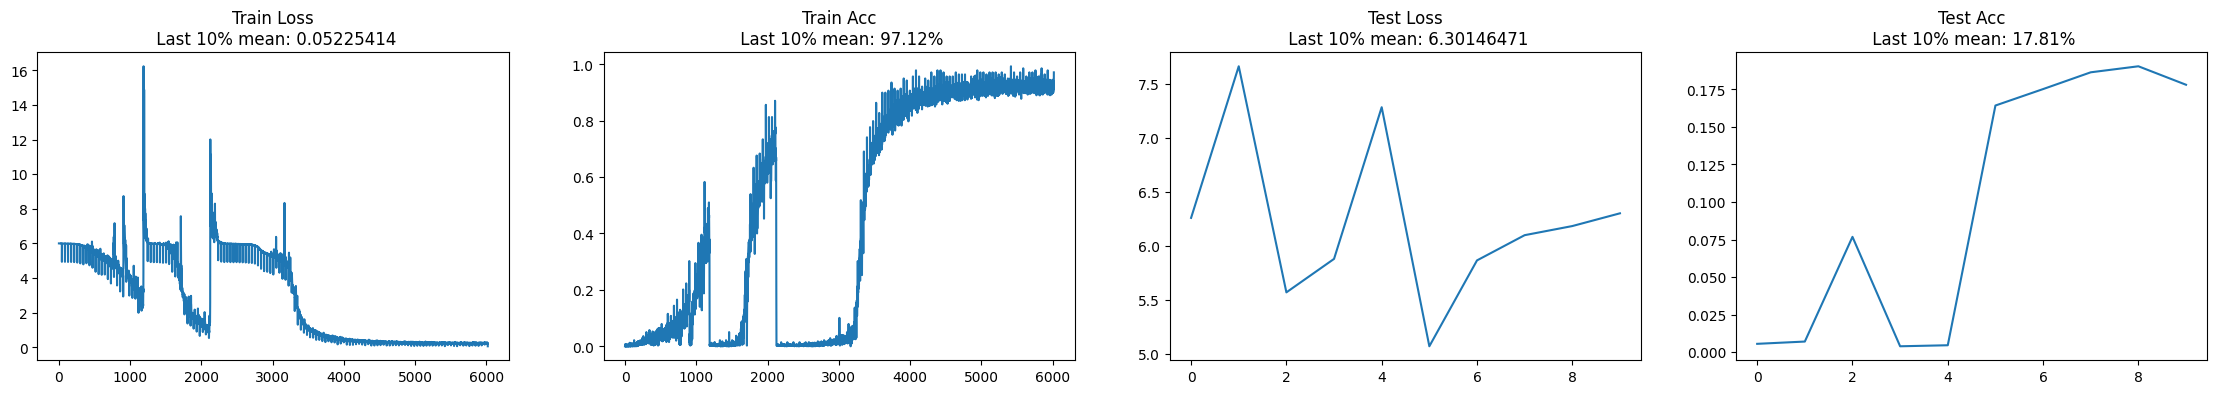

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# log_dir = f'{checkpoint_path}/logger'

log_dir = '/mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/all embedding/checkpoints/all embedding/magnet_None_1_0094_None_1_/decoder/magnet/logger'
# load the logger
with open(log_dir + '/logger_train_loss.pkl', 'rb') as f:
    logger_train_loss = pickle.load(f)
with open(log_dir + '/logger_train_PSNR.pkl', 'rb') as f:
    logger_train_mae = pickle.load(f)
with open(log_dir + 'logger_lr.pkl', 'rb') as f:
    logger_lr = pickle.load(f)
with open(log_dir + 'logger_val_loss.pkl.pkl', 'rb') as f:
    logger_val_loss = pickle.load(f)
with open(log_dir + 'logger_val_PSNR.pkl', 'rb') as f:
    logger_val_mae = pickle.load(f)

visualization_num = int(len(logger_val_loss)*0.1)

plt.figure(figsize=(28, 4))

plt.subplot(1,5,1)
plt.plot(logger_train_loss)
train_loss_last = np.mean(logger_train_loss[-visualization_num:])
plt.title('Train Loss\n Last 10% mean: {:.8f}'.format(train_loss_last))

plt.subplot(1,5,2)
plt.plot(logger_train_mae)
train_mae_last = np.mean(logger_train_mae[-visualization_num:])
plt.title('Train MAE\n Last 10% mean: {:.2%}'.format(train_mae_last))

plt.subplot(1,5,3)
plt.plot(logger_lr)
train_lr = np.mean(logger_lr[-visualization_num:])
plt.title('Learning Rate\n Last 10% mean: {:.8f}'.format(train_lr))

plt.subplot(1,5,4)
plt.plot(logger_val_loss)
test_loss_last = np.mean(logger_val_loss[-visualization_num:])
plt.title('Test Loss\n Last 10% mean: {:.8f}'.format(test_loss_last))

plt.subplot(1,5,5)
plt.plot(logger_val_mae)
test_mae_last = np.mean(logger_val_mae[-visualization_num:])
plt.title('Test Acc\n Last 10% mean: {:.2%}'.format(test_mae_last))


In [3]:
from Data.utils import transfer_date_to_id

mag_feature_list = []
h_feature_list = []
start_date = transfer_date_to_id(2020, 6, 30)
end_date = transfer_date_to_id(2024, 6, 30)
print(start_date,end_date)


val_loader = Solardataloader_subset.get_loader_by_time(load_imgs=False,time_step=12*24*60,time_interval=[start_date,end_date],modal_list = args.modal_list, enhance_list = [args.image_preprocess[0],0,0], batch_size = 5, shuffle=False, num_workers=args.num_workers)

with torch.no_grad():
    SolarModel = SolarModel.eval()
    Decoder = Decoder.eval()
    for i, data in enumerate(val_loader):
        mag_image = data[:,0,:,:,:] # [batch, channel, height, width]
        h_image = data[:,1,:,:,:]
        mag_image = mag_image.to(device)
        h_image = h_image.to(device)
        mag_features = SolarModel.encode_mag(mag_image)   #shape = [batch_size, length,embed_dim]
        H_features = SolarModel.encode_H(h_image)
        mag_features, h_features = mag_features[:,1:,:], h_features[:,1:,:]  ##all embedding
        mag_recon = Decoder(mag_features)
        
        break

vis_ids = np.arange(num_class)

mag_image = mag_image[vis_ids].cpu().numpy()
mag_image = transfer_log1p(mag_image)

mag_recon = mag_recon[vis_ids].cpu().numpy()
mag_recon = transfer_log1p(mag_recon)


17280 20160
 magnet has 72889 samples
 0094 has 120206 samples
All modal has 1 samples


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(mag_image[i,0,:,:], cmap='gray')
    plt.axis('off')
    plt.title('Original')
    plt.subplot(2, 5, i+6)
    plt.imshow(mag_recon[i,0,:,:], cmap='gray')
    plt.axis('off')
    plt.title('Reconstructed')


images of different modals

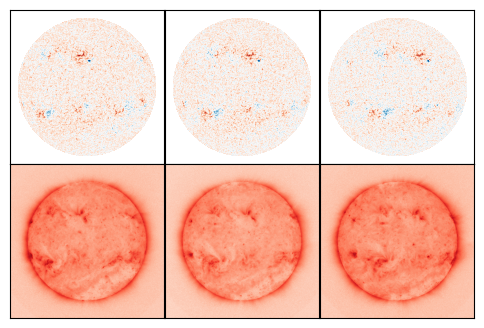

In [20]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from Data.Solardataloader import transfer_log1p

fig,ax = plt.subplots(2,3,figsize=(6,4))

for i in range(2,5):
    vmin = 0
    vmax = 10
    # path = f'/mnt/nas/home/zhouyuqing/downloads/AIA2013040{i}_0000_0335.fits'
    path = f'/mnt/nas/home/huxing/202407/nas/data/hmi/fits/hmi.M_720s.2010070{i}_150000_TAI.fits'
    img = fits.open(path)[1].data
    img = transfer_log1p(img)
    ax[0,i-2].imshow(img,cmap='RdBu_r')
    ax[0, i-2].set_xticks([])
    ax[0, i-2].set_yticks([])
    path = f'/mnt/nas/home/zhouyuqing/downloads/AIA2010070{i}_1000_0094.fits'
    img = fits.open(path)[1].data
    img = transfer_log1p(img)
    ax[1,i-2].imshow(img,cmap='Reds')
    ax[1, i-2].set_xticks([])
    ax[1, i-2].set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)


plt.show()
